In [2]:
# initial setup
import os
import sys
from collections import defaultdict
os.environ['DATABASE_URL'] = 'postgres:///awrdata'

%matplotlib inline
import matplotlib.pyplot as plt
os.chdir('/users/dane/src/datatools/ipy/notebooks/pt/dev/')
sys.path.append('/users/dane/src/datatools/analytics/')

from pertest.util import *
from dtutil.sqltools import query_to_dataframe, get_cursor_from_url

import numpy as np
import pandas as pd

cursor = get_cursor_from_url()

# Memory Metrics

In [2]:
query = """
select m.id as m_id, m.name as m_name, m.test_case,
       case
           when m.mean is null then m.value
           else m.mean
       end as mean,
       m.upper, m.lower, m.meas_type,
       t.value as tval, t.passed, t.build, t.id as t_id from pertest_test as t
    inner join pertest_metric as m on t.metric_id = m.id
where m.name like '%$M'
order by t.build
"""
df = query_to_dataframe(cursor, query)
df['value'] = df.tval
df.head()

,m_id,m_name,test_case,mean,upper,lower,meas_type,tval,passed,build,t_id,value
0,75935,AxPerf:Memory$M,2_18_GHZ_Power_Divider_WideBandSystem@7 Stage ...,39.256,0.015,0.015,VAL_PCT,39.256,1,8600.05,2645338,39.256
1,76085,AxPerf:Memory$M,AX_OneResonator@Resonator,23.716,0.010,0.010,VAL_PCT,23.716,1,8600.05,2645488,23.716
2,76535,AxPerf:Memory$M,tt11261_mlin_AFS@Axiem_deembed_AFS,21.900,0.015,0.015,VAL_PCT,21.768,1,8600.05,2645938,21.768
3,76035,AxPerf:Memory$M,attenuator_simplified_AFS_test@Axiem,23.692,0.010,0.010,VAL_PCT,23.692,1,8600.05,2645438,23.692
4,76185,AxPerf:Memory$M,Filter_example_with_diagonals_AFS@axiem filter...,24.652,0.015,0.015,VAL_PCT,24.652,1,8600.05,2645588,24.652


## Look at the range of deviations in memory

We want to evaluate a percent tolerance range for memory.  The first step is to look at all the metrics without a level shift and then see how many failures we would have with a specific error band.

In [15]:
error_bands_to_test = [0.04, .05, 0.06, 0.07, 0.08]
failures = defaultdict(list)
for e in error_bands_to_test:
    num_failures = 0
    for m, tests in df.groupby('m_id'):
        if not level_shift2(tests):
            nom = tests.iloc[0]['mean']
            high = tests.tval.max()
            low = tests.tval.min()
            pct_low = (nom - low) / nom
            pct_high = (high - nom) / nom
            pct = max(pct_low, pct_high)
            if pct >= e:
                num_failures += 1
                failures[e].append(m)
    print('For {:.0f} % there are {} failures'.format(e*100, num_failures))

For 4 % there are 18 failures
For 5 % there are 8 failures
For 6 % there are 6 failures
For 7 % there are 4 failures
For 8 % there are 3 failures


It seems that 4% is too low but the drop off after 5% is pretty gradual.  Let's look at the failures for 5%.

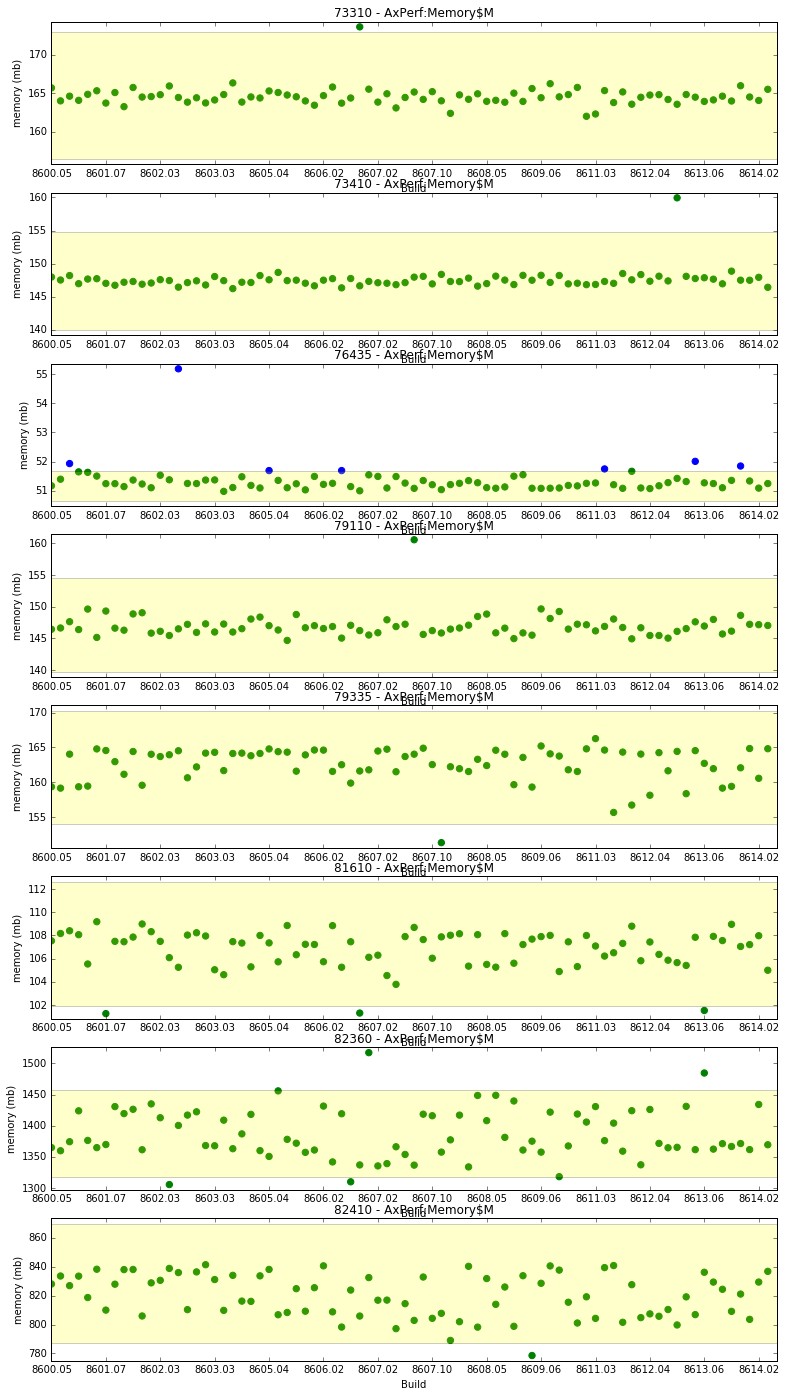

In [17]:
plotm(failures[.05])

Looking at this it seems that the failures are quite random and that using a moving average would solve these failures.

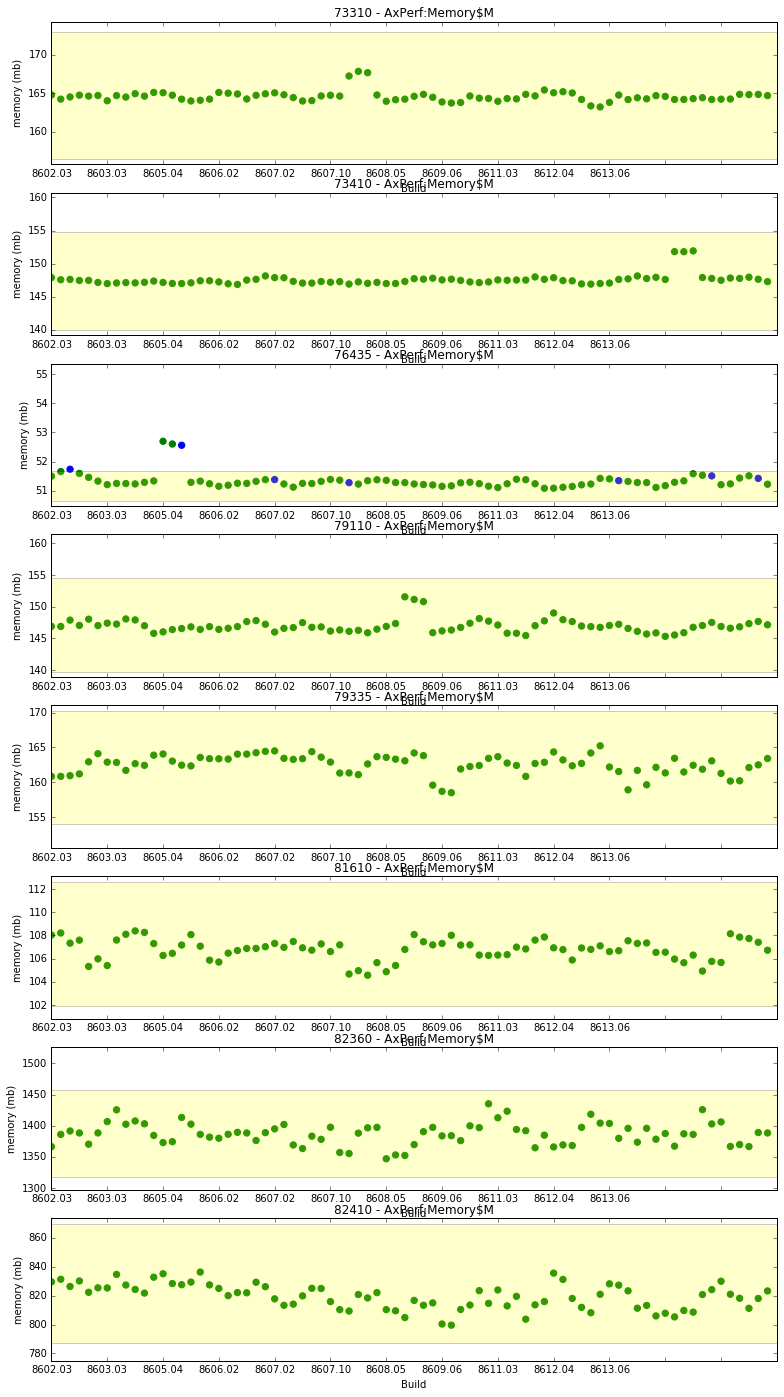

In [29]:
ml = failures[.05]
plotrm(ml)

Seeing these rolling means leads me to believe that the current 1-time exception is a better mechanism for testing than this rolling mean which seems to delay decisions and make a bigger issue of the exceptions.  Neither method would solve the issue with metric 76435 and manual intervention would be required in either case.


## Level Shifts

We want to make sure the level shifts we are excluding are reasonable

26 level metrics have level shifts and are being excluded


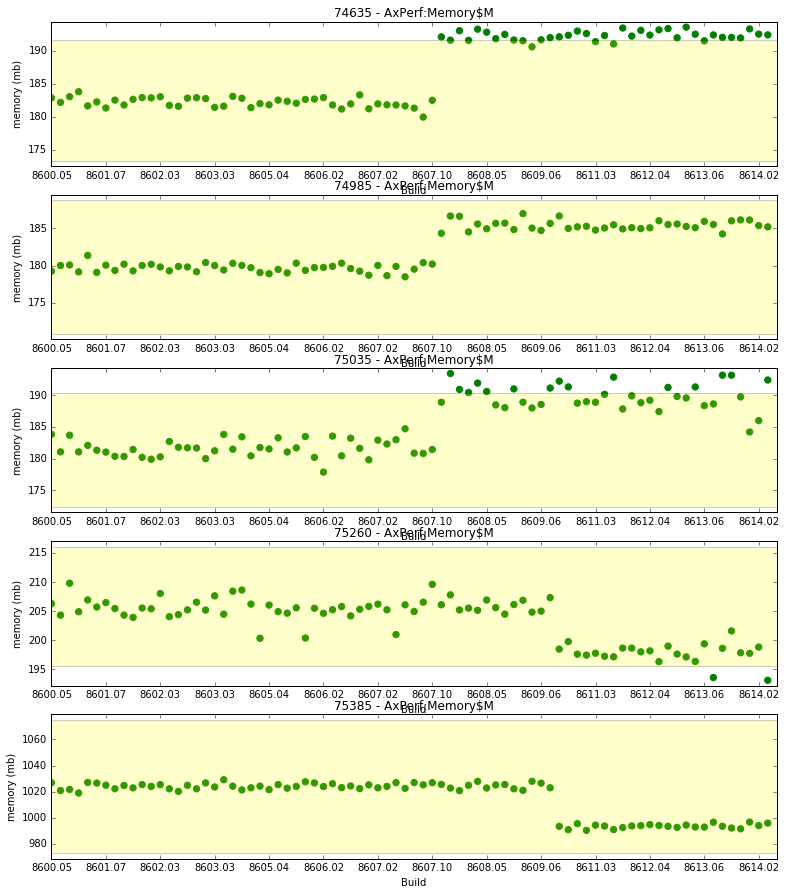

In [28]:
# how many level shifts are there?
lsh = [m for m, tests in df.groupby('m_id') if level_shift2(tests)]
print(len(lsh), 'level metrics have level shifts and are being excluded')
plotm(lsh[5:10])

# Conclusion

Using MED_PCT with a 5% upper and lower limit produces an acceptable number of false positives assuming that either a 3-point rolling mean or a 1-time exception rule is applied.

In [15]:
import json
df = pd.read_csv('../data/v14_b60-73.csv')
metric_settings = {}
for m_id, items in df[df.m_name.apply(lambda x: '$M' in x)].groupby('m_id'):
    row = items.iloc[0]
    pmean = items[:15].t_value.mean()
    metric_settings[m_id] = dict(id=int(m_id), name=row['m_name'], test_case=row.test_case, current_sequence=0,
                                 meas_type='MEAN_PCT', mean=pmean, lower=.05, upper=.05)

In [16]:
data = list(metric_settings.values())
print(type(data))
print(len(data))
with open('memory_settings.json', 'w') as fp:
    fp.write(json.dumps(data, indent=2))

    

<class 'list'>
398
